# Mutation Variation

In [11]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [6]:
# %%R
# # R script for looping throught the htseq outputs and merge them into one matrix
# # Written by Ahmed Alhendi
# Usage example:  Rscript htseq-combine_all.R {workdir} {Reacount_matrix_output_name}

# args <- commandArgs(TRUE)
# myoutname <- as.character(args[2])

# ##Read files names
# directory <- "/research/projects/chlamydomonas/MAexpression/data/gene_count"

# sampleFiles <- grep("_genes_count", list.files(directory), value=TRUE)
# fileNames <- sub("_genes_count", "", sampleFiles)
# list_files <- list.files(path = directory, pattern = "_genes_counts")

# cov <- list()
# for (i in sampleFiles) {
# filepath <- file.path(directory, paste(i))
# cov[[i]] <- read.table(filepath, sep = "\t", header=F, stringsAsFactors=FALSE)
# colnames(cov[[i]]) <- c("ENSEMBL_GeneID", i)
# }

# ##DataFrame
# df <- Reduce(function(x,y) merge(x = x, y = y, by ="ENSEMBL_GeneID"), cov)
# #print(sprintf("Exported merged table within work directory in txt and Rdata format with file name merged_%s_%s", make.names(format(Sys.time(),"%b_%d_%Y_%H_%M_%S_%Z")), myoutname))
# write.table(df,paste(directory, myoutname,".txt",sep=""), sep="\t", quote= F, row.names = F)
             
# head(df)

# # #LIBRARY SIZE NORMALIZATION
# # library("scone")
# # df <- read.table('/research/projects/chlamydomonas/MAexpression/data/gene_countNA.txt', header=TRUE, row.names="ENSEMBL_GeneID")
# # new_df <- df[-c(1, 2, 3, 4, 5), ]
# # df_matrix = data.matrix(new_df)
# # df_UQ <- UQ_FN(df_matrix)
# # write.table(df_UQ, paste(directory, "_UQ_norm", ".txt", sep=""), sep="\t", quote = F)
# # # write.table(df_UQ, paste(directory, myoutname, ".txt", sep=""), sep="\t", quote = F, row.names="ENSEMBL_GeneID" )

### Keys

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import mannwhitneyu
stats.junk = lambda chisq, df: stats.chi2.sf(chisq, df)
import csv

CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]

CC2344_list = [ i + '-rep1' for i in CC2344] + [ i + '-rep2' for i in CC2344] + [ i + '-rep3' for i in CC2344]
CC2931_list = [ i + '-rep1' for i in CC2931] + [ i + '-rep2' for i in CC2931] + [ i + '-rep3' for i in CC2931]
    
CC2344_rep = [ i + '-rep1' for i in CC2344[1:]] + [ i + '-rep2' for i in CC2344[1:]] + [ i + '-rep3' for i in CC2344[1:]]
CC2931_rep = [ i + '-rep1' for i in CC2931[1:]] + [ i + '-rep2' for i in CC2931[1:]] + [ i + '-rep3' for i in CC2931[1:]]

dic_gen = {'CC2344-L1': 912.356113, 'CC2344-L10': 917.129696, 'CC2344-L11': 889.5859554, 'CC2344-L12': 950.0552184, 'CC2344-L13': 961.4186064,
           'CC2344-L14': 931.447801, 'CC2344-L15': 946.6643063, 'CC2344-L2': 923.1078072, 'CC2344-L3': 1000.469526, 'CC2344-L4': 808.9505794,
           'CC2344-L5': 957.6380465, 'CC2344-L6': 970.6307256, 'CC2344-L7': 990.9451516, 'CC2344-L8': 1009.966123, 'CC2344-L9': 901.0619061, 
           'CC2931-L1': 1050.109001, 'CC2931-L10': 1097.978141, 'CC2931-L11': 1021.13559, 'CC2931-L13': 1041.362593, 
           'CC2931-L14': 1016.111493, 'CC2931-L15': 1052.540951, 'CC2931-L2': 1056.765369, 'CC2931-L3': 1000.399127, 'CC2931-L4': 1011.411706,
           'CC2931-L5': 993.8603657, 'CC2931-L6': 1083.095655, 'CC2931-L7': 1067.34507, 'CC2931-L9': 1079.236285}

dic_mut = {'CC2344-L1': 396, 'CC2344-L10': 59, 'CC2344-L11': 46, 'CC2344-L12': 74, 'CC2344-L13': 49, 'CC2344-L14': 46, 'CC2344-L15': 53, 
           'CC2344-L2': 80, 'CC2344-L3': 63, 'CC2344-L4': 24, 'CC2344-L5': 68, 'CC2344-L6': 38, 'CC2344-L7': 45, 'CC2344-L8': 75, 'CC2344-L9': 27, 
           'CC2931-L1': 89, 'CC2931-L10': 87, 'CC2931-L11': 85, 'CC2931-L13': 97, 'CC2931-L14': 79, 'CC2931-L15': 141, 'CC2931-L2': 123,
           'CC2931-L3': 52, 'CC2931-L4': 100, 'CC2931-L5': 335, 'CC2931-L6': 84, 'CC2931-L7': 72, 'CC2931-L9': 113}

generations = pd.Series(dic_gen)
mutations = pd.Series(dic_mut)

CC2344_gen_mean = sum([dic_gen[i] for i in CC2344[1:]])/len([dic_gen[i] for i in CC2344[1:]])
CC2931_gen_mean = sum([dic_gen[i] for i in CC2931[1:]])/len([dic_gen[i] for i in CC2931[1:]])

### Observed vs Expected Mutations

In [2]:
CC2931_mut_chi = pd.DataFrame()
CC2344_mut_chi = pd.DataFrame()

## Based on the generation time and the known mutation rate, how many mutations do we expect to see
# CHI-SQUARE ANALYSIS (actual vs expected mutations)

for i in CC2931[1:]:
    CC2931_mut_chi.at[i, 'exp_mut'] = generations[i]*(11.5*10**(-10))*(111*10**(6))
    CC2931_mut_chi.at[i, 'mut'] = dic_mut[i]
    CC2931_mut_chi.at[i, 'stat'] = (CC2931_mut_chi.at[i, 'mut'] - CC2931_mut_chi.at[i, 'exp_mut'])**2/(CC2931_mut_chi.at[i, 'exp_mut'])
CC2931_mut_chi['chi_square'] = CC2931_mut_chi['stat'].sum()
CC2931_mut_chi['chi_sq_min_outliers'] = CC2931_mut_chi['stat'].sum() - CC2931_mut_chi.at['CC2931-L5','exp_mut']
CC2931_mut_chi['p-val_1'] = stats.junk(CC2931_mut_chi['chi_square'], len(CC2931_mut_chi.index.values))
CC2931_mut_chi['p-val_2'] = stats.junk(CC2931_mut_chi['chi_sq_min_outliers'], len(CC2931_mut_chi.index.values) - 1)

for i in CC2344[1:]:
    CC2344_mut_chi.at[i, 'exp_mut'] = generations[i]*(11.5*10**(-10))*(111*10**(6))
    CC2344_mut_chi.at[i, 'mut'] = dic_mut[i]
    CC2344_mut_chi.at[i, 'stat'] = (CC2344_mut_chi.at[i, 'mut'] - CC2344_mut_chi.at[i, 'exp_mut'])**2/(CC2344_mut_chi.at[i, 'exp_mut'])
CC2344_mut_chi['chi_square'] = CC2344_mut_chi['stat'].sum()
CC2344_mut_chi['chi_sq_min_outliers'] = CC2344_mut_chi['stat'].sum() - CC2344_mut_chi.at['CC2344-L1','exp_mut']
CC2344_mut_chi['p-val_1'] = stats.junk(CC2344_mut_chi['chi_square'], len(CC2344_mut_chi.index.values))
CC2344_mut_chi['p-val_2'] = stats.junk(CC2344_mut_chi['chi_sq_min_outliers'], len(CC2344_mut_chi.index.values) - 1)

### Cleaning Up The Data Provided From DESeq2

In [3]:
## CLEANING UP THE DATA PROVIDED FROM DESEQ2
CC2931_new_columns = []
CC2344_new_columns = []

CC2931_rel = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/normalized_raw_counts/gene_count_deseq_CC2931.txt', delimiter = "\t")
CC2344_rel = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/normalized_raw_counts/gene_count_deseq_CC2344.txt', delimiter = "\t")

for i in CC2931_rel.columns:
    i = i.replace('_', '-')
    for j in CC2931_list:
        if j in i:
            CC2931_new_columns.append(j)
            
for i in CC2344_rel.columns:
    i = i.replace('_', '-')
    for j in CC2344_list:
        if j in i:
            CC2344_new_columns.append(j)

CC2931_rel.columns = CC2931_new_columns
CC2344_rel.columns = CC2344_new_columns
CC2931_rel.index.name = 'genes'
CC2344_rel.index.name = 'genes'
genes = list(CC2931_rel.index.values)

CC2931_rel['CC2931-ANC'] = CC2931_rel[['CC2931-ANC-rep1', 'CC2931-ANC-rep2', 'CC2931-ANC-rep3']].mean(axis = 1)
CC2344_rel['CC2344-ANC'] = CC2344_rel[['CC2344-ANC-rep1', 'CC2344-ANC-rep2', 'CC2344-ANC-rep3']].mean(axis = 1)

CC2931_rel.drop(['CC2931-ANC-rep1', 'CC2931-ANC-rep2', 'CC2931-ANC-rep3'], inplace=True, axis=1)
CC2344_rel.drop(['CC2344-ANC-rep1', 'CC2344-ANC-rep2', 'CC2344-ANC-rep3'], inplace=True, axis=1)

for i in genes:
    if CC2344_rel.at[i, 'CC2344-ANC'] == 0:
        CC2344_rel.drop(i, inplace = True)
    if CC2931_rel.at[i, 'CC2931-ANC'] == 0:
        CC2931_rel.drop(i, inplace = True)
        
## EXPORTING FILTERED RAW COUNTS
CC2931_rel.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2931_raw', sep = "\t", index = True, header = True)
CC2344_rel.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2344_raw', sep = "\t", index = True, header = True)

### Identifying Low and High Expression Genes

In [4]:
import pandas as pd
import seaborn as sns

###################################################################
## IDENTIFYING HIGH AND LOW EXPRESSION GENES IN ANCESTORS AND MA ##
###################################################################

CC2931_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2931_raw', delimiter = '\t')
CC2344_raw = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2344_raw', delimiter = '\t')
CC2931_raw.set_index('genes', inplace = True)
CC2344_raw.set_index('genes', inplace = True)

for i in CC2344[1:] + CC2931[1:]:
    if 'CC2931' in i:
        CC2931_raw[i] = CC2931_raw[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
    if 'CC2344' in i:
        CC2344_raw[i] = CC2344_raw[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)

CC2344_10per = CC2344_raw['CC2344-ANC'].quantile(0.1)
CC2931_10per = CC2931_raw['CC2931-ANC'].quantile(0.1)
CC2344_90per = CC2344_raw['CC2344-ANC'].quantile(0.9)
CC2931_90per = CC2931_raw['CC2931-ANC'].quantile(0.9)

CC2344_low_exp = list(CC2344_raw.loc[CC2344_raw['CC2344-ANC'] <= CC2344_10per].index.values)
CC2931_low_exp = list(CC2931_raw.loc[CC2931_raw['CC2931-ANC'] <= CC2931_10per].index.values)

CC2344_hi_exp = list(CC2344_raw.loc[CC2344_raw['CC2344-ANC'] >= CC2344_90per].index.values)
CC2931_hi_exp = list(CC2931_raw.loc[CC2931_raw['CC2931-ANC'] >= CC2931_90per].index.values)

HL_MAgenes = {}
for i in CC2344[1:] + CC2931[1:]:
    if 'CC2344' in i:
        HL_MAgenes[i + "_low"] = list(CC2344_raw.loc[CC2344_raw[i] <= CC2344_10per].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2344_raw.loc[CC2344_raw[i] >= CC2344_90per].index.values)
    if 'CC2931' in i:
        HL_MAgenes[i + "_low"] = list(CC2931_raw.loc[CC2931_raw[i] <= CC2931_10per].index.values)
        HL_MAgenes[i + "_hi"] = list(CC2931_raw.loc[CC2931_raw[i] >= CC2931_90per].index.values)

#############################################################################       
## CHECKING INTERSECTION SETS OF HIGH AND LOW EXPRESSION FOR EACH GENOTYPE ##
#############################################################################

verify_hi_hi = list(set(CC2344_hi_exp).symmetric_difference(set(CC2931_hi_exp)))
verify_hi_low = list(set.intersection(set(CC2344_hi_exp), set(CC2931_low_exp))) # noticed points of intersection between sites of high and low expression
verify_low_hi = list(set.intersection(set(CC2344_low_exp), set(CC2931_hi_exp)))
verify_low_low = list(set(CC2344_low_exp).symmetric_difference(set(CC2931_low_exp)))

### Relative Fold Change

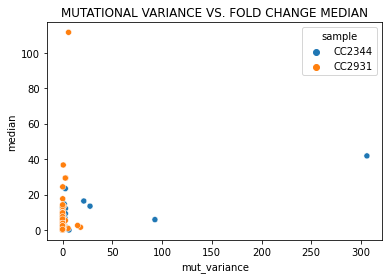

In [9]:
CC2931_rel = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2931_raw', delimiter = '\t')
CC2344_rel = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2344_raw', delimiter = '\t')
CC2344_rel.set_index('genes', inplace = True)
CC2931_rel.set_index('genes', inplace = True)

for i in ['CC2344_rel_1', 'CC2931_rel_1', 'CC2344_sum_per_mut', 'CC2931_sum_per_mut']:
    exec('{} = pd.DataFrame()'.format(i))

#####################################
## TAKING THE RELATIVE FOLD CHANGE ##
#####################################

for i in list(CC2344_rel.columns) + list(CC2931_rel.columns):
    if 'CC2931' in i:
        CC2931_rel[i] = CC2931_rel[i]/CC2931_rel['CC2931-ANC']
    if 'CC2344' in i:
        CC2344_rel[i] = CC2344_rel[i]/CC2344_rel['CC2344-ANC']

for i in CC2344[1:] + CC2931[1:]:
    if 'CC2931' in i:
        CC2931_rel[i] = CC2931_rel[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
        CC2931_rel_1[i] = CC2931_rel[i]
    if 'CC2344' in i:
        CC2344_rel[i] = CC2344_rel[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
        CC2344_rel_1[i] = CC2344_rel[i]
        
CC2344_rel_1.set_index(CC2344_rel.index.values, inplace = True)
CC2931_rel_1.set_index(CC2931_rel.index.values, inplace = True)
        
#########################################################
## MEAN/MEDIAN/VARIANCE OF DOWN AND UP-REGULATED GENES ##
#########################################################

CC2344_rel_1['mean'] = CC2344_rel_1[CC2344[1:]].mean(axis = 1) 
CC2931_rel_1['mean'] = CC2931_rel_1[CC2931[1:]].mean(axis = 1)

CC2344_rel_1['median'] = CC2344_rel_1[CC2344[1:]].median(axis = 1) 
CC2931_rel_1['median'] = CC2931_rel_1[CC2931[1:]].median(axis = 1)

CC2344_rel_1['var'] = CC2344_rel_1[CC2344[1:]].var(axis = 1)
CC2931_rel_1['var'] = CC2931_rel_1[CC2931[1:]].var(axis = 1)

##############################################
## ABSOLUTE FOLD CHANGE PER GENOTYPE SAMPLE ##
##############################################
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum'] = CC2344_rel_1[i].sum()
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum'] = CC2931_rel_1[i].sum()

## ABSOLUTE FOLD CHANGE PER MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_mut'] = CC2344_sum_per_mut.at[i, 'sum']/dic_mut[i]
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_mut'] = CC2931_sum_per_mut.at[i, 'sum']/dic_mut[i]

## ABSOLUTE FOLD CHANGE PER EXPECTED MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2344_sum_per_mut.at[i, 'sum']/CC2344_mut_chi.at[i, 'exp_mut']
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2931_sum_per_mut.at[i, 'sum']/CC2931_mut_chi.at[i, 'exp_mut']

# ## SEABORN
# a = sns.distplot(CC2931_sum_per_mut['sum_per_mut'])
# a = sns.distplot(CC2931_sum_per_mut['sum_per_exp_mut'])
# plt.xlim(0, 450)
# plt.title('CC2931 - RELATIVE FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2931_RELATIVE_FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

# b = sns.distplot(CC2344_sum_per_mut['sum_per_mut'])
# b = sns.distplot(CC2344_sum_per_mut['sum_per_exp_mut'])
# plt.xlim(0, 1000)
# plt.title('CC2344 - RELATIVE FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2344_RELATIVE_FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
## CONVERTING DATAFRAME USING PD.MELT
CC2344_sum_per_mut = CC2344_sum_per_mut.reset_index()
CC2344_RELATIVE_FOLD = pd.melt(CC2344_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2344_RELATIVE_FOLD['sample'] = 'CC2344'
CC2344_RELATIVE_FOLD['fold'] = 'relative fold'

CC2931_sum_per_mut = CC2931_sum_per_mut.reset_index()
CC2931_RELATIVE_FOLD = pd.melt(CC2931_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2931_RELATIVE_FOLD['sample'] = 'CC2931'
CC2931_RELATIVE_FOLD['fold'] = 'relative fold'

#############################################################################################################################
    
for i in ['CC2931_rel_per_gen', 'CC2344_rel_per_gen', 'CC2931_rel_var', 'CC2344_rel_var', 'correlation_1', 'correlation_2']:
    exec('{} = pd.DataFrame()'.format(i))

## FINDING THE RELATIVE FOLD CHANGE OVER MA GENERATIONS (VARIANCE PER GENE)

CC2344_rel_per_gen['mut_variance'] = CC2344_rel[CC2344[1:]].var(axis = 1)/CC2344_gen_mean
CC2931_rel_per_gen['mut_variance'] = CC2931_rel[CC2931[1:]].var(axis = 1)/CC2931_gen_mean

## EXPORTING AS CSV
CC2931_rel_per_gen.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/CC2931_pergen', sep = "\t", header = True, index = True)
CC2344_rel_per_gen.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/CC2344_pergen', sep = "\t", header = True, index = True)

###################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND RELATIVE FOLD SUM ##
###################################################################

# CC2344_rel_1['sum'] = CC2344_rel_1[CC2344[1:]].sum(axis = 1)
# CC2931_rel_1['sum'] = CC2931_rel_1[CC2931[1:]].sum(axis = 1)

# correlation_1['sum'] = CC2344_rel_1['sum']
# correlation_1['mut_variance'] = CC2344_rel_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['sum'] = CC2931_rel_1['sum']
# correlation_2['mut_variance'] = CC2931_rel_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'sum', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE SUM')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/mut_var_vs_fold_sum.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

####################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND RELATIVE FOLD MEAN ##
####################################################################

# for i in ['correlation_1', 'correlation_2']:
#     exec('{} = pd.DataFrame()'.format(i))
    
# correlation_1['mean'] = CC2344_rel_1['mean']
# correlation_1['mut_variance'] = CC2344_rel_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['mean'] = CC2931_rel_1['mean']
# correlation_2['mut_variance'] = CC2931_rel_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'mean', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEAN')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/mut_var_vs_fold_mean.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

######################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND RELATIVE FOLD MEDIAN ##
######################################################################

# for i in ['correlation_1', 'correlation_2']:
#     exec('{} = pd.DataFrame()'.format(i))
    
# correlation_1['median'] = CC2344_rel_1['median']
# correlation_1['mut_variance'] = CC2344_rel_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['median'] = CC2931_rel_1['median']
# correlation_2['mut_variance'] = CC2931_rel_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'median', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEDIAN')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/relative_fold_change/mut_var_vs_fold_median.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

# ######################################################################
# ## FINDING THE VARIANCE OF THE RELATIVE FOLD MA LINES FROM ANCESTOR ##
# ######################################################################

# for i in CC2931[1:] + CC2344[1:]:
#     if 'CC2931' in i:
#         CC2931_rel_var[i + '_dif_ANC'] = (CC2931_rel[i] - CC2931_rel['CC2931-ANC'])**2
#         CC2931_rel_var['sum'] = CC2931_rel_var[CC2931_rel_var.columns].sum(axis = 1)
#         CC2931_rel_var['variance'] = CC2931_rel_var['sum']/13
#         CC2931_rel_var['mut_variance'] = CC2931_rel_var['variance']/CC2931_gen_mean
#     if 'CC2344' in i:
#         CC2344_rel_var[i + '_dif_ANC'] = (CC2344_rel[i] - CC2344_rel['CC2344-ANC'])**2
#         CC2344_rel_var['sum'] = CC2344_rel_var[CC2344_rel_var.columns].sum(axis = 1)
#         CC2344_rel_var['variance'] = CC2344_rel_var['sum']/15
#         CC2344_rel_var['mut_variance'] = CC2344_rel_var['variance']/CC2344_gen_mean

#### SIGNIFICANCE OF MUTATIONAL VARIANCE (VM)

In [12]:
for c in ['CC2344_high', 'CC2344_low', 'CC2344_high1', 'CC2344_low1', 'CC2931_high', 'CC2931_low', 'CC2931_high1', 'CC2931_low1']:
     exec('{} = pd.DataFrame()'.format(c))

###########################################
## RELATIVE FOLD VARIANCE PER GENERATION ##
###########################################

CC2344_high['mut_variance'] = CC2344_rel_per_gen['mut_variance'].loc[CC2344_hi_exp].values.tolist()
CC2344_high['expression'] = 'high'
CC2344_high['id'] = 'CC2344'
CC2344_low['mut_variance'] = CC2344_rel_per_gen['mut_variance'].loc[CC2344_low_exp].values.tolist()
CC2344_low['expression'] = 'low'
CC2344_low['id'] = 'CC2344'

CC2931_high['mut_variance'] = CC2931_rel_per_gen['mut_variance'].loc[CC2931_hi_exp].values.tolist()
CC2931_high['expression'] = 'high'
CC2931_high['id'] = 'CC2931'
CC2931_low['mut_variance'] = CC2931_rel_per_gen['mut_variance'].loc[CC2931_low_exp].values.tolist()
CC2931_low['expression'] = 'low'
CC2931_low['id'] = 'CC2931'

rel_per_gen = pd.concat([CC2344_high, CC2344_low, CC2931_high, CC2931_low], axis = 0)

##########################################
## RELATIVE FOLD VARIANCE FROM ANCESTOR ##
##########################################

CC2344_high1['mut_variance'] = CC2344_rel_var['mut_variance'].loc[CC2344_hi_exp].values.tolist()
CC2344_high1['expression'] = 'high'
CC2344_high1['id'] = 'CC2344'
CC2344_low1['mut_variance'] = CC2344_rel_var['mut_variance'].loc[CC2344_low_exp].values.tolist()
CC2344_low1['expression'] = 'low'
CC2344_low1['id'] = 'CC2344'

CC2931_high1['mut_variance'] = CC2931_rel_var['mut_variance'].loc[CC2931_hi_exp].values.tolist()
CC2931_high1['expression'] = 'high'
CC2931_high1['id'] = 'CC2931'
CC2931_low1['mut_variance'] = CC2931_rel_var['mut_variance'].loc[CC2931_low_exp].values.tolist()
CC2931_low1['expression'] = 'low'
CC2931_low1['id'] = 'CC2931'

rel_fold_change = pd.concat([CC2344_high1, CC2344_low1, CC2931_high1, CC2931_low1], axis = 0)

#########################
## MANN WHITNEY U TEST ##
#########################
U1, p1 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2344_low['mut_variance'].values.tolist())
U2, p2 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2344_low1['mut_variance'].values.tolist())
U3, p3 = mannwhitneyu(CC2931_high['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U4, p4 = mannwhitneyu(CC2931_high1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

## COMPARING THE MEDIAN ACROSS GENOTYPES
U5, p5 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2931_high['mut_variance'].values.tolist())
U6, p6 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2931_high1['mut_variance'].values.tolist())
U7, p7 = mannwhitneyu(CC2344_low['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U8, p8 = mannwhitneyu(CC2344_low1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

print(p1, p2, p3, p4)
print(p5, p6, p7, p8)

## SEABORN BOXPLOTS
# sns.boxplot(data = rel_per_gen, x = 'expression', y = 'mut_variance', hue = 'id')
# sns.boxplot(data = rel_fold_change, x = 'expression', y = 'mut_variance', hue = 'id')

6.849326991274002e-238 3.1836735487880585e-242 0.0 0.0
4.185016473985431e-20 3.587858113886656e-77 0.038150760379558536 0.17309847368428327


### Absolute Fold Change

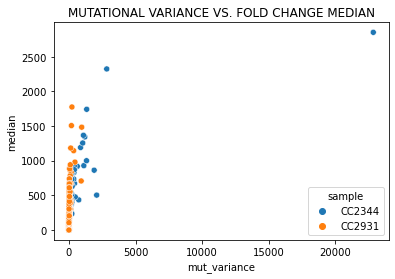

In [11]:
CC2931_abs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2931_raw', delimiter = '\t')
CC2344_abs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/CC2344_raw', delimiter = '\t')
CC2931_abs.set_index('genes', inplace = True)
CC2344_abs.set_index('genes', inplace = True)

for i in ['CC2931_abs_per_gen', 'CC2344_abs_per_gen', 'CC2344_abs_1', 'CC2931_abs_1', 'CC2344_sum_per_mut', 'CC2931_sum_per_mut']:
    exec('{} = pd.DataFrame()'.format(i))

for i in CC2344_rep + CC2931_rep + ['CC2931-ANC', 'CC2344-ANC']:
    if 'CC2931' in i:
        CC2931_abs[i] = CC2931_abs[i]/CC2931_abs['CC2931-ANC'].median()
    if 'CC2344' in i:
        CC2344_abs[i] = CC2344_abs[i]/CC2344_abs['CC2344-ANC'].median()
        
# TAKING THE MEAN OF THREE REPS
for i in CC2344[1:] + CC2931[1:]:
    if 'CC2931' in i:
        CC2931_abs[i] = CC2931_abs[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
        CC2931_abs_1[i] = CC2931_abs[i]
    if 'CC2344' in i:
        CC2344_abs[i] = CC2344_abs[[i + '-rep1', i + '-rep2', i + '-rep3']].mean(axis = 1)
        CC2344_abs_1[i] = CC2344_abs[i]
        
CC2344_abs_1.set_index(CC2344_abs.index.values, inplace = True)
CC2931_abs_1.set_index(CC2931_abs.index.values, inplace = True)
        
## MEAN/MEDIAN/VARIANCE OF DOWN AND UP-REGULATED GENES
CC2344_abs_1['mean'] = CC2344_abs_1[CC2344[1:]].mean(axis = 1) 
CC2931_abs_1['mean'] = CC2931_abs_1[CC2931[1:]].mean(axis = 1)

CC2344_abs_1['median'] = CC2344_abs_1[CC2344[1:]].median(axis = 1) 
CC2931_abs_1['median'] = CC2931_abs_1[CC2931[1:]].median(axis = 1)

CC2344_abs_1['var'] = CC2344_abs_1[CC2344[1:]].var(axis = 1)
CC2931_abs_1['var'] = CC2931_abs_1[CC2931[1:]].var(axis = 1)

## ABSOLUTE FOLD CHANGE PER LINE
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum'] = CC2344_abs[i].sum()
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum'] = CC2931_abs[i].sum()

## ABSOLUTE FOLD CHANGE PER MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_mut'] = CC2344_sum_per_mut.at[i, 'sum']/dic_mut[i]
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_mut'] = CC2931_sum_per_mut.at[i, 'sum']/dic_mut[i]

## ABSOLUTE FOLD CHANGE PER EXPECTED MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2344_sum_per_mut.at[i, 'sum']/CC2344_mut_chi.at[i, 'exp_mut']
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2931_sum_per_mut.at[i, 'sum']/CC2931_mut_chi.at[i, 'exp_mut']
    
# ## SEABORN
# a = sns.distplot(CC2931_sum_per_mut['sum_per_mut'])
# a = sns.distplot(CC2931_sum_per_mut['sum_per_exp_mut'])
# plt.xlim(0, 3000)
# plt.title('CC2931 - ABSOLUTE FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2931_ABSOLUTE_FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

# b = sns.distplot(CC2344_sum_per_mut['sum_per_mut'])
# b = sns.distplot(CC2344_sum_per_mut['sum_per_exp_mut'])
# plt.xlim(0, 5000)
# plt.title('CC2344 - ABSOLUTE FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2344_ABSOLUTE_FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
## CONVERTING DATAFRAME USING PD.MELT
CC2344_sum_per_mut = CC2344_sum_per_mut.reset_index()
CC2344_ABSOLUTE_FOLD = pd.melt(CC2344_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2344_ABSOLUTE_FOLD['sample'] = 'CC2344'
CC2344_ABSOLUTE_FOLD['fold'] = 'absolute fold'

CC2931_sum_per_mut = CC2931_sum_per_mut.reset_index()
CC2931_ABSOLUTE_FOLD = pd.melt(CC2931_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2931_ABSOLUTE_FOLD['sample'] = 'CC2931'
CC2931_ABSOLUTE_FOLD['fold'] = 'absolute fold'

#############################################################################################################################

for i in ['CC2931_abs_per_gen', 'CC2344_abs_per_gen', 'correlation_1', 'correlation_2', 'CC2931_abs_var', 'CC2344_abs_var']:
    exec('{} = pd.DataFrame()'.format(i))

## TAKING THE VARIANCE OF THE MA LINES ACROSS EACH ROW (PER GENE)
CC2931_abs_per_gen['mut_variance'] = CC2931_abs[CC2931[1:]].var(axis = 1)/CC2931_gen_mean
CC2344_abs_per_gen['mut_variance'] = CC2344_abs[CC2344[1:]].var(axis = 1)/CC2344_gen_mean

# EXPORTING AS CSV
CC2931_abs_per_gen.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/CC2931_pergen', sep = "\t", header = True, index = True)
CC2344_abs_per_gen.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/CC2344_pergen', sep = "\t", header = True, index = True)

###################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND ABSOLUTE FOLD SUM ##
###################################################################

# CC2344_abs_1['sum'] = CC2344_abs_1[CC2344[1:]].sum(axis = 1)
# CC2931_abs_1['sum'] = CC2931_abs_1[CC2931[1:]].sum(axis = 1)

# correlation_1['sum'] = CC2344_abs_1['sum']
# correlation_1['mut_variance'] = CC2344_abs_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['sum'] = CC2931_abs_1['sum']
# correlation_2['mut_variance'] = CC2931_abs_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'sum', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE SUM')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/mut_var_vs_fold_sum.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

####################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND ABSOLUTE FOLD MEAN ##
####################################################################

# for i in ['correlation_1', 'correlation_2']:
#     exec('{} = pd.DataFrame()'.format(i))
    
# correlation_1['mean'] = CC2344_abs_1['mean']
# correlation_1['mut_variance'] = CC2344_abs_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['mean'] = CC2931_abs_1['mean']
# correlation_2['mut_variance'] = CC2931_abs_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'mean', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEAN')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/mut_var_vs_fold_mean.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

######################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND ABSOLUTE FOLD MEDIAN ##
######################################################################

# for i in ['correlation_1', 'correlation_2']:
#     exec('{} = pd.DataFrame()'.format(i))
    
# correlation_1['median'] = CC2344_abs_1['median']
# correlation_1['mut_variance'] = CC2344_abs_per_gen['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['median'] = CC2931_abs_1['median']
# correlation_2['mut_variance'] = CC2931_abs_per_gen['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mut_variance', y = 'median', hue = 'sample')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEDIAN')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/absolute_fold_change/mut_var_vs_fold_median.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

######################################################################
## FINDING THE VARIANCE OF THE RELATIVE FOLD MA LINES FROM ANCESTOR ##
######################################################################

for i in CC2931[1:] + CC2344[1:]:
    if 'CC2931' in i:
        CC2931_abs_var[i + '_dif_ANC'] = (CC2931_abs[i] - CC2931_abs['CC2931-ANC'])**2
        CC2931_abs_var['sum'] = CC2931_abs_var[CC2931_abs_var.columns].sum(axis = 1)
        CC2931_abs_var['variance'] = CC2931_abs_var['sum']/13
        CC2931_abs_var['mut_variance'] = CC2931_abs_var['variance']/CC2931_gen_mean
    if 'CC2344' in i:
        CC2344_abs_var[i + '_dif_ANC'] = (CC2344_abs[i] - CC2344_abs['CC2344-ANC'])**2
        CC2344_abs_var['sum'] = CC2344_abs_var[CC2344_abs_var.columns].sum(axis = 1)
        CC2344_abs_var['variance'] = CC2344_abs_var['sum']/15
        CC2344_abs_var['mut_variance'] = CC2344_abs_var['variance']/CC2344_gen_mean

#### SIGNIFICANCE OF MUTATIONAL VARIANCE (VM)

In [14]:
for c in ['CC2344_high', 'CC2344_low', 'CC2344_high1', 'CC2344_low1', 'CC2931_high', 'CC2931_low', 'CC2931_high1', 'CC2931_low1']:
     exec('{} = pd.DataFrame()'.format(c))
        
# intersection_set = list(set.intersection(set(CC2344_hi_exp), set(CC2344_abs_per_gen.index.values)))

###########################################
## ABSOLUTE FOLD VARIANCE PER GENERATION ##
###########################################

CC2344_high['mut_variance'] = CC2344_abs_per_gen['mut_variance'].loc[list(set.intersection(set(CC2344_hi_exp), set(CC2344_abs_per_gen.index.values)))].values.tolist()
CC2344_high['expression'] = 'high'
CC2344_high['id'] = 'CC2344'
CC2344_low['mut_variance'] = CC2344_abs_per_gen['mut_variance'].loc[list(set.intersection(set(CC2344_low_exp), set(CC2344_abs_per_gen.index.values)))].values.tolist()
CC2344_low['expression'] = 'low'
CC2344_low['id'] = 'CC2344'

CC2931_high['mut_variance'] = CC2931_abs_per_gen['mut_variance'].loc[list(set.intersection(set(CC2931_hi_exp), set(CC2931_abs_per_gen.index.values)))].values.tolist()
CC2931_high['expression'] = 'high'
CC2931_high['id'] = 'CC2931'
CC2931_low['mut_variance'] = CC2931_abs_per_gen['mut_variance'].loc[list(set.intersection(set(CC2931_low_exp), set(CC2931_abs_per_gen.index.values)))].values.tolist()
CC2931_low['expression'] = 'low'
CC2931_low['id'] = 'CC2931'

abs_per_gen = pd.concat([CC2344_high, CC2344_low, CC2931_high, CC2931_low], axis = 0)

##########################################
## ABSOLUTE FOLD VARIANCE FROM ANCESTOR ##
##########################################

CC2344_high1['mut_variance'] = CC2344_abs_var['mut_variance'].loc[list(set.intersection(set(CC2344_hi_exp), set(CC2344_abs_var.index.values)))].values.tolist()
CC2344_high1['expression'] = 'high'
CC2344_high1['id'] = 'CC2344'
CC2344_low1['mut_variance'] = CC2344_abs_var['mut_variance'].loc[list(set.intersection(set(CC2344_low_exp), set(CC2344_abs_var.index.values)))].values.tolist()
CC2344_low1['expression'] = 'low'
CC2344_low1['id'] = 'CC2344'

CC2931_high1['mut_variance'] = CC2931_abs_var['mut_variance'].loc[list(set.intersection(set(CC2931_hi_exp), set(CC2931_abs_var.index.values)))].values.tolist()
CC2931_high1['expression'] = 'high'
CC2931_high1['id'] = 'CC2931'
CC2931_low1['mut_variance'] = CC2931_abs_var['mut_variance'].loc[list(set.intersection(set(CC2931_low_exp), set(CC2931_abs_var.index.values)))].values.tolist()
CC2931_low1['expression'] = 'low'
CC2931_low1['id'] = 'CC2931'

abs_fold_change = pd.concat([CC2344_high, CC2344_low, CC2931_high, CC2931_low], axis = 0)

#########################
## MANN WHITNEY U TEST ##
#########################
U1, p1 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2344_low['mut_variance'].values.tolist())
U2, p2 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2344_low1['mut_variance'].values.tolist())
U3, p3 = mannwhitneyu(CC2931_high['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U4, p4 = mannwhitneyu(CC2931_high1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

## COMPARING THE MEDIAN ACROSS GENOTYPES
U5, p5 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2931_high['mut_variance'].values.tolist())
U6, p6 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2931_high1['mut_variance'].values.tolist())
U7, p7 = mannwhitneyu(CC2344_low['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U8, p8 = mannwhitneyu(CC2344_low1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

print(p1, p2, p3, p4)
print(p5, p6, p7, p8)

# ## SEABORN
# sns.boxplot(data = abs_per_gen, x = 'expression', y = 'mut_variance', hue = 'id')
# sns.boxplot(data = abs_fold_change, x = 'expression', y = 'mut_variance', hue = 'id')

0.0 0.0 0.0 0.0
0.4606099850213154 1.952126317656827e-06 5.387059425911183e-24 2.942561057729175e-17


### Log2Fold - Mutational Variance (Vm)

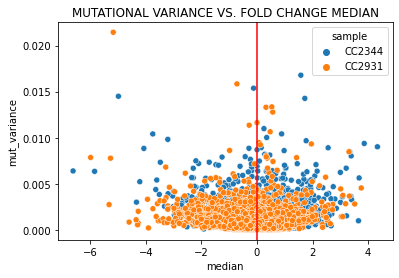

In [15]:
import pandas as pd

for i in ['CC2931_log2Fold', 'CC2344_log2Fold', 'combined_log2Fold', 'CC2344_sum_per_mut', 'CC2931_sum_per_mut', 'correlation_1', 'correlation_2']:
    exec('{} = pd.DataFrame()'.format(i))

filenames = CC2344[1:] + CC2931[1:]

## THE MEAN OF THE GENERATIONS ACROSS MA LINES IN EACH GENOTYPE
combined_gen_mean = sum([dic_gen[i] for i in CC2344[1:] + CC2931[1:]])/len([dic_gen[i] for i in CC2344[1:] + CC2931[1:]])

for i in CC2931[1:]:
    CC2931_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
for i in CC2344[1:]:
    CC2344_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = "\t")['log2FoldChange']
for i in CC2931[1:] + CC2344[1:]:
    combined_log2Fold[i] = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/genes_log2fold/' + i, delimiter = '\t')['log2FoldChange']

## MEAN/MEDIAN/VARIANCE OF DOWN AND UP-REGULATED GENES
CC2344_log2Fold['mean'] = CC2344_log2Fold[CC2344[1:]].mean(axis = 1) 
CC2931_log2Fold['mean'] = CC2931_log2Fold[CC2931[1:]].mean(axis = 1)

CC2344_log2Fold['median'] = CC2344_log2Fold[CC2344[1:]].median(axis = 1) 
CC2931_log2Fold['median'] = CC2931_log2Fold[CC2931[1:]].median(axis = 1)

CC2344_log2Fold['var'] = CC2344_log2Fold[CC2344[1:]].var(axis = 1)
CC2931_log2Fold['var'] = CC2931_log2Fold[CC2931[1:]].var(axis = 1)

## ABSOLUTE FOLD CHANGE PER LINE
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum'] = CC2344_log2Fold[i].sum()
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum'] = CC2931_log2Fold[i].sum()

## ABSOLUTE FOLD CHANGE PER MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_mut'] = CC2344_sum_per_mut.at[i, 'sum']/dic_mut[i]
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_mut'] = CC2931_sum_per_mut.at[i, 'sum']/dic_mut[i]

## ABSOLUTE FOLD CHANGE PER EXPECTED MUTATION
for i in CC2344[1:]:
    CC2344_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2344_sum_per_mut.at[i, 'sum']/CC2344_mut_chi.at[i, 'exp_mut']
for i in CC2931[1:]:
    CC2931_sum_per_mut.at[i, 'sum_per_exp_mut'] = CC2931_sum_per_mut.at[i, 'sum']/CC2931_mut_chi.at[i, 'exp_mut']

# ## SEABORN
# a = sns.distplot(CC2931_sum_per_mut['sum_per_mut'])
# a = sns.distplot(CC2931_sum_per_mut['sum_per_exp_mut'])
# plt.axvline(0, color = 'black')
# plt.xlim(-30, 20)
# plt.title('CC2931 - LOG2FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2931_LOG2FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

# b = sns.distplot(CC2344_sum_per_mut['sum_per_mut'])
# b = sns.distplot(CC2344_sum_per_mut['sum_per_exp_mut'])
# plt.axvline(0, color = 'black')
# plt.title('CC2344 - LOG2FOLD SUM PER MUTATION')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/CC2344_LOG2FOLD_SUM_PER_MUT.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
    
## CONVERTING DATAFRAME USING PD.MELT
CC2344_sum_per_mut = CC2344_sum_per_mut.reset_index()
CC2344_LOG2FOLD = pd.melt(CC2344_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2344_LOG2FOLD['sample'] = 'CC2344'
CC2344_LOG2FOLD['fold'] = 'log2fold'

CC2931_sum_per_mut = CC2931_sum_per_mut.reset_index()
CC2931_LOG2FOLD = pd.melt(CC2931_sum_per_mut, id_vars = 'index', value_vars = ['sum_per_mut', 'sum_per_exp_mut'])
CC2931_LOG2FOLD['sample'] = 'CC2931'
CC2931_LOG2FOLD['fold'] = 'log2fold'

#########################
## MUTATIONAL VARIANCE ##
#########################

CC2344_log2Fold['mut_variance'] = CC2344_log2Fold[CC2344[1:]].var(axis = 1)/CC2344_gen_mean
CC2931_log2Fold['mut_variance'] = CC2931_log2Fold[CC2931[1:]].var(axis = 1)/CC2931_gen_mean
combined_log2Fold['mut_variance'] = combined_log2Fold.var(axis = 1)/combined_gen_mean

##############################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND LOG2FOLD SUM ##
##############################################################

# CC2344_log2Fold['sum'] = CC2344_log2Fold[CC2344[1:]].sum(axis = 1)
# CC2931_log2Fold['sum'] = CC2931_log2Fold[CC2931[1:]].sum(axis = 1)

# correlation_1['sum'] = CC2344_log2Fold['sum']
# correlation_1['mut_variance'] = CC2344_log2Fold['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['sum'] = CC2931_log2Fold['sum']
# correlation_2['mut_variance'] = CC2931_log2Fold['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'sum', y = 'mut_variance', hue = 'sample')
# plt.axvline(0, color = 'red')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE SUM')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/mut_var_vs_fold_sum.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

####################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND LOG2FOLD MEAN ##
####################################################################

# for i in ['correlation_1', 'correlation_2']:
#     exec('{} = pd.DataFrame()'.format(i))
    
# correlation_1['mean'] = CC2344_log2Fold['mean']
# correlation_1['mut_variance'] = CC2344_log2Fold['mut_variance']
# correlation_1['sample'] = 'CC2344'

# correlation_2['mean'] = CC2931_log2Fold['mean']
# correlation_1['mut_variance'] = CC2931_log2Fold['mut_variance']
# correlation_2['sample'] = 'CC2931'

# correlation = pd.concat([correlation_1, correlation_2], axis = 0)

# sns.scatterplot(data = correlation, x = 'mean', y = 'mut_variance', hue = 'sample')
# plt.axvline(0, color = 'red')
# plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEAN')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/mut_var_vs_fold_mean.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

######################################################################
## CORRELATION BETWEEN MUTATIONAL VARIANCE AND LOG2FOLD MEDIAN ##
######################################################################

for i in ['correlation_1', 'correlation_2']:
    exec('{} = pd.DataFrame()'.format(i))
    
correlation_1['median'] = CC2344_log2Fold['median']
correlation_1['mut_variance'] = CC2344_log2Fold['mut_variance']
correlation_1['sample'] = 'CC2344'

correlation_2['median'] = CC2931_log2Fold['median']
correlation_2['mut_variance'] = CC2931_log2Fold['mut_variance']
correlation_2['sample'] = 'CC2931'

correlation = pd.concat([correlation_1, correlation_2], axis = 0)

sns.scatterplot(data = correlation, x = 'median', y = 'mut_variance', hue = 'sample')
plt.axvline(0, color = 'red')
plt.title('MUTATIONAL VARIANCE VS. FOLD CHANGE MEDIAN')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/log2fold/mut_var_vs_fold_median.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')


#### SIGNIFICANCE OF MUTATIONAL VARIANCE (VM)

In [16]:
for c in ['CC2344_high', 'CC2344_low', 'CC2344_high1', 'CC2344_low1', 'CC2931_high', 'CC2931_low', 'CC2931_high1', 'CC2931_low1']:
     exec('{} = pd.DataFrame()'.format(c))

##############################################
## LOG2FOLD VARIANCE PER AVERAGE GENERATION ##
##############################################

CC2344_high['mut_variance'] = CC2344_log2Fold['mut_variance'].loc[CC2344_hi_exp].values.tolist()
CC2344_high['expression'] = 'high'
CC2344_high['id'] = 'CC2344'
CC2344_low['mut_variance'] = CC2344_log2Fold['mut_variance'].loc[CC2344_low_exp].values.tolist()
CC2344_low['expression'] = 'low'
CC2344_low['id'] = 'CC2344'

CC2931_high['mut_variance'] = CC2931_log2Fold['mut_variance'].loc[CC2931_hi_exp].values.tolist()
CC2931_high['expression'] = 'high'
CC2931_high['id'] = 'CC2931'
CC2931_low['mut_variance'] = CC2931_log2Fold['mut_variance'].loc[CC2931_low_exp].values.tolist()
CC2931_low['expression'] = 'low'
CC2931_low['id'] = 'CC2931'

CC2344_high_median = CC2344_high['mut_variance'].median(axis = 0, skipna = True)
CC2344_low_median = CC2344_low['mut_variance'].median(axis = 0, skipna = True)
CC2931_high_median = CC2931_high['mut_variance'].median(axis = 0, skipna = True)
CC2931_low_median = CC2931_low['mut_variance'].median(axis = 0, skipna = True)

log2fold_change = pd.concat([CC2344_high, CC2344_low, CC2931_high, CC2931_low], axis = 0)

#######################################################
## COMBINED LOG2FOLD VARIANCE PER AVERAGE GENERATION ##
#######################################################

CC2344_high1['mut_variance'] = combined_log2Fold['mut_variance'].loc[CC2344_hi_exp].values.tolist()
CC2344_high1['expression'] = 'high'
CC2344_high1['id'] = 'CC2344'
CC2344_low1['mut_variance'] = combined_log2Fold['mut_variance'].loc[CC2344_low_exp].values.tolist()
CC2344_low1['expression'] = 'low'
CC2344_low1['id'] = 'CC2344'

CC2931_high1['mut_variance'] = combined_log2Fold['mut_variance'].loc[CC2931_hi_exp].values.tolist()
CC2931_high1['expression'] = 'high'
CC2931_high1['id'] = 'CC2931'
CC2931_low1['mut_variance'] = combined_log2Fold['mut_variance'].loc[CC2931_low_exp].values.tolist()
CC2931_low1['expression'] = 'low'
CC2931_low1['id'] = 'CC2931'

CC2344_high_median = CC2344_high1['mut_variance'].median(axis = 0, skipna = True)
CC2344_low_median = CC2344_low1['mut_variance'].median(axis = 0, skipna = True)
CC2931_high_median = CC2931_high1['mut_variance'].median(axis = 0, skipna = True)
CC2931_low_median = CC2931_low1['mut_variance'].median(axis = 0, skipna = True)

combined_log2fold_change = pd.concat([CC2344_high, CC2344_low, CC2931_high, CC2931_low], axis = 0)

#########################
## MANN WHITNEY U TEST ##
#########################
U1, p1 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2344_low['mut_variance'].values.tolist())
U2, p2 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2344_low1['mut_variance'].values.tolist())
U3, p3 = mannwhitneyu(CC2931_high['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U4, p4 = mannwhitneyu(CC2931_high1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

## COMPARING THE MEDIAN ACROSS GENOTYPES
U5, p5 = mannwhitneyu(CC2344_high['mut_variance'].values.tolist(), CC2931_high['mut_variance'].values.tolist())
U6, p6 = mannwhitneyu(CC2344_high1['mut_variance'].values.tolist(), CC2931_high1['mut_variance'].values.tolist())
U7, p7 = mannwhitneyu(CC2344_low['mut_variance'].values.tolist(), CC2931_low['mut_variance'].values.tolist())
U8, p8 = mannwhitneyu(CC2344_low1['mut_variance'].values.tolist(), CC2931_low1['mut_variance'].values.tolist())

print(p1, p2, p3, p4)
print(p5, p6, p7, p8)

# ## SEABORN
# sns.boxplot(data = log2fold_change, x = 'expression', y = 'mut_variance', hue = 'id')
# sns.boxplot(data = combined_log2fold_change, x = 'expression', y = 'mut_variance')

7.330221812082584e-175 1.3440365276803627e-235 0.0 6.8554571747739e-247
1.2015718741719393e-45 0.009873751426269048 1.1155737301487103e-08 0.011218635362001595


### Identifying cis mutations

In [ ]:
## COMBINING ALL DEGs INTO THE SAME DATAFRAME

# import pandas as pd
# import gffpandas.gffpandas as gffpd

# adj_pval = pd.DataFrame()

# genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
#            'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
#            'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
#            'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
#            'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
#            'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
#            'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']

# for i in genes:
#     loc = '/research/projects/chlamydomonas/MAexpression/analysis/DEGs/' + i
#     DF = pd.read_csv(loc, delimiter = ",")
#     DF[[i]] = DF[['Unnamed: 0']]
#     adj_pval = pd.concat([adj_pval, DF[i]], axis = 1)
#     adj_pval[i] = adj_pval[i].fillna('')

# adj_pval.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv', header = True, index = False)

#############################################################################################################################

## ISOLATING THE LOCATIONS OF DEGs

# annotation = gffpd.read_gff3('/research/projects/chlamydomonas/MAexpression/data/genome_info/CC4532.v1_1.genes.primaryTrs.gff3')
# annotation_df = annotation.df
# annotation_df['attributes'] = annotation_df['attributes'].str.split(';', expand = True)

# total_genes = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/total_genes.csv')

# CC2344 = ['CC2344-ANC', "CC2344-L1", "CC2344-L2", "CC2344-L3", "CC2344-L4", "CC2344-L5", "CC2344-L6", "CC2344-L7", "CC2344-L8", "CC2344-L9", "CC2344-L10", "CC2344-L11", "CC2344-L12", "CC2344-L13", "CC2344-L14", "CC2344-L15"]
# CC2931 = ["CC2931-ANC", "CC2931-L1", "CC2931-L2", "CC2931-L3", "CC2931-L4", "CC2931-L5", "CC2931-L6", "CC2931-L7", "CC2931-L9", "CC2931-L10", "CC2931-L11", "CC2931-L13", "CC2931-L14", "CC2931-L15"]
# list_noANC = CC2344[1:] + CC2931[1:]
# dic = {list_noANC[i]:genes[i] for i in range(len(genes))}

# for i in genes:
#     gene_list = total_genes[i].values.tolist()
#     gene_list = [x for x in gene_list if pd.isnull(x) == False]
#     feature_by_attribute = annotation.get_feature_by_attribute('ID', gene_list)
#     feature_by_attribute.to_csv(i + '.csv')

In [62]:
## OPENING FILE WITH MUTATIONS AND THEIR KNOWN LOCATIONS IN V6
mutations = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/mutation_info/v6_coordinates.bed', delimiter = '\t', names = ['chromosome', 'start', 'end', 'sample'])
mutations = mutations.sort_values('sample') # There are two missing samples CC2931_8 and CC2931_12, the first one has no recorded mutations

## REMOVING ALL CC2931_12 MUTATIONS FROM THE DATAFRAME
missing_CC2931_12 = mutations.loc[mutations['sample'] == 'CC2931_12'].index.values
mutations.drop(missing_CC2931_12, inplace = True)

## CREATING A FUNCTION THAT INDENTIFIES POSSIBLE CIS MUTATIONS
def cis_mutations(mutations, bin_width):
    '''this function provides a dataframe containing sites that are within a certain distance from each mutation'''
    
    CC2344 = ["CC2344_1", "CC2344_2", "CC2344_3", "CC2344_4", "CC2344_5", "CC2344_6", "CC2344_7", "CC2344_8", "CC2344_9", "CC2344_10", "CC2344_11", "CC2344_12", "CC2344_13", "CC2344_14", "CC2344_15"]
    CC2931 = ["CC2931_1", "CC2931_2", "CC2931_3", "CC2931_4", "CC2931_5", "CC2931_6", "CC2931_7", "CC2931_9", "CC2931_10", "CC2931_11", "CC2931_13", "CC2931_14", "CC2931_15"]
    total = CC2344 + CC2931
    genes = ['CC2344.resSig_L1.genes', 'CC2344.resSig_L2.genes', 'CC2344.resSig_L3.genes', 'CC2344.resSig_L4.genes',
           'CC2344.resSig_L5.genes', 'CC2344.resSig_L6.genes', 'CC2344.resSig_L7.genes', 'CC2344.resSig_L8.genes',
           'CC2344.resSig_L9.genes', 'CC2344.resSig_L10.genes', 'CC2344.resSig_L11.genes', 'CC2344.resSig_L12.genes',
           'CC2344.resSig_L13.genes', 'CC2344.resSig_L14.genes', 'CC2344.resSig_L15.genes', 'CC2931.resSig_L1.genes',
           'CC2931.resSig_L2.genes', 'CC2931.resSig_L3.genes', 'CC2931.resSig_L4.genes', 'CC2931.resSig_L5.genes',
           'CC2931.resSig_L6.genes', 'CC2931.resSig_L7.genes', 'CC2931.resSig_L9.genes', 'CC2931.resSig_L10.genes',
           'CC2931.resSig_L11.genes', 'CC2931.resSig_L13.genes', 'CC2931.resSig_L14.genes', 'CC2931.resSig_L15.genes']
    dic = {total[i]:genes[i] for i in range(len(genes))}
    
    cis_mutations = pd.DataFrame()
    for i in list(mutations.index.values):
        DEGs = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/degs_with_locations/' + dic[mutations.at[i, 'sample']] + '.csv')
        DEGs['sample'] = mutations.at[i, 'sample']
        mut = mutations.at[i, 'start']
        start = mut - bin_width
        end = mut + bin_width
        spec_chrom = DEGs.loc[DEGs['seq_id'] == mutations.at[i,'chromosome']]
        for a in list(spec_chrom.index.values):
            spec_start = spec_chrom.at[a, 'start']
            spec_end = spec_chrom.at[a, 'end']
            if start <= spec_start and end >= spec_start:
                cis_mutations = cis_mutations.append(spec_chrom.loc[spec_chrom['start'] == spec_start])
            else:
                if start <= spec_end and end >= spec_end:
                    cis_mutations = cis_mutations.append(spec_chrom.loc[spec_chrom['start'] == spec_start])
    return cis_mutations

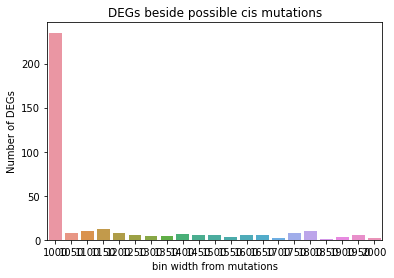

In [149]:
## FREQUENCY COUNTS OF NUMBER OF DEGs WITHIN GIVEN BANDWIDTH OF MUTATION
frequency_table = pd.DataFrame()
possible_cis = pd.DataFrame()
# bin_width = [10, 50, 100, 150, 200, 250, 300, 350, 400]
# bin_width = [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 5000, 10000]
bin_width = [1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]
for i in bin_width:
    results = cis_mutations(mutations, i)
    results['bin_width'] = i
    results['attributes'] = results['attributes'].replace('ID=', '', regex = True)
    possible_cis = possible_cis.append(results)
    frequency_table.at[i, 'cum_counts'] = len(results)
    
bin_width = list(frequency_table.index.values)
length = [i for i in range(len(frequency_table.index.values))]
for i in length[1:]:
    frequency_table.at[bin_width[0], 'add_counts'] = frequency_table.at[bin_width[0], 'cum_counts']
    frequency_table.at[bin_width[i], 'add_counts'] = frequency_table.at[bin_width[i], 'cum_counts'] - frequency_table.at[bin_width[i-1],'cum_counts']
frequency_table = frequency_table.reset_index()

## CLASSIFYING POTENTIAL CIS MUTATIONS WITH HIGH/LOW/NEITHER EXPRESSION
possible_cis['attributes'] = possible_cis['attributes'].str.replace('ID=', '', regex = True)
possible_cis['sample'] = possible_cis['sample'].str.replace('_', '-L', regex = True)
possible_cis['expression'] = 'neither'
possible_cis.drop_duplicates(keep='first', inplace=True)
possible_cis = possible_cis.reset_index()
for i in list(possible_cis.index.values):
    if possible_cis.at[i, 'attributes'] in HL_MAgenes[possible_cis.at[i, 'sample'] + "_low"]:
        possible_cis.at[i, 'expression'] = 'low'
    else:
        if possible_cis.at[i, 'attributes'] in HL_MAgenes[possible_cis.at[i, 'sample'] + "_hi"]:
            possible_cis.at[i, 'expression'] = 'high'
            
## ISOLATING THE VALUES WITH STRICTLY HIGH AND LOW EXPRESSIONS
possible_cis_no_neither = possible_cis.loc[possible_cis['expression'].isin(['high', 'low'])]

## GRAPH OF DEGS BESIDE POSSIBLE CIS MUTATIONS
ax = sns.barplot(data = frequency_table, x = 'index', y = 'add_counts')
ax.set_title('DEGs beside possible cis mutations')
plt.xlabel('bin width from mutations')
plt.ylabel('Number of DEGs')
# plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/DEGs_near_cis_mutations.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')
possible_cis.to_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_1000_to_2000.csv', sep = "\t", index = False, header = True)

In [ ]:
## GRAPH OF THE TYPE OF EXPRESSION PRODUCED BY CIS MUTATIONS
ax = sns.countplot(x = 'bin_width', hue = 'expression', data = possible_cis)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) 
for p in ax.patches:
    txt = str(p.get_height().round(2))
    txt_x = p.get_x() 
    txt_y = p.get_height()
    ax.text(txt_x,txt_y,txt)
ax.set_title('Type of expression produced by cis mutations')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/expression_near_cis_mutations.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

In [ ]:
## GRAPH OF THE TYPE OF EXPRESSION (WITHOUT NEITHER) PRODUCED BY CIS MUTATIONS
a = sns.countplot(x = 'bin_width', hue = 'expression', data = possible_cis_no_neither)
a.set_title('Type of expression produced by cis mutations')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/images/expression_without_neither_near_cis_mutations.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

In [150]:
## COMPARE FOLD CHANGE OF GENES WITH MUTATIONS WITHIN N-BP OF GENE TO OTHER GENES
possible_cis_stats = pd.DataFrame()
# possible_cis = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_10_to_400.csv', delimiter = '\t')
# possible_cis = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_10_to_10000.csv', delimiter = '\t')
possible_cis = pd.read_csv('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/bin_1000_to_2000.csv', delimiter = '\t')

for i in possible_cis.index.values:
    if 'CC2344' in possible_cis.at[i, 'sample']:
        attributes = possible_cis.at[i, 'attributes']
        sample = possible_cis.at[i, 'sample']
        possible_cis.at[i, 'log2Fold'] = CC2344_log2Fold.at[attributes, sample]
        possible_cis.at[i, 'abs_fold'] = CC2344_abs.at[attributes, sample]
        possible_cis.at[i, 'rel_fold'] = CC2344_rel.at[attributes, sample]
    if 'CC2931' in possible_cis.at[i, 'sample']:
        attributes = possible_cis.at[i, 'attributes']
        sample = possible_cis.at[i, 'sample']
        possible_cis.at[i, 'log2Fold'] = CC2931_log2Fold.at[attributes, sample]
        possible_cis.at[i, 'abs_fold'] = CC2931_abs.at[attributes, sample]
        possible_cis.at[i, 'rel_fold'] = CC2931_rel.at[attributes, sample]

# bin_width = [10, 50, 100, 150, 200, 250, 300, 350, 400]
# bin_width = [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 5000, 10000]
bin_width = [1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000]
for i in bin_width:
    specific_bin = possible_cis.loc[possible_cis['bin_width'] == i]
    possible_cis_stats.at[i, 'log2Fold'] = specific_bin['log2Fold'].sum()
    possible_cis_stats.at[i, 'abs_fold'] = specific_bin['abs_fold'].sum()
    possible_cis_stats.at[i, 'rel_fold'] = specific_bin['rel_fold'].sum()
possible_cis_stats = possible_cis_stats.reset_index()
possible_cis_stats = pd.melt(possible_cis_stats, id_vars=['index'], value_vars=['log2Fold', 'abs_fold', 'rel_fold'])

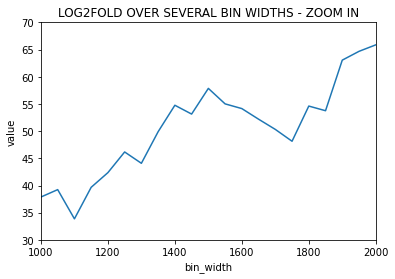

In [158]:
sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'log2Fold'], x="index", y = 'value')
plt.xlabel('bin_width')
plt.xlim(1000, 2000)
plt.ylim(30, 70)
plt.title("LOG2FOLD OVER SEVERAL BIN WIDTHS - ZOOM IN")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/log2fold_over_bin_widths_zoom_in_2.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

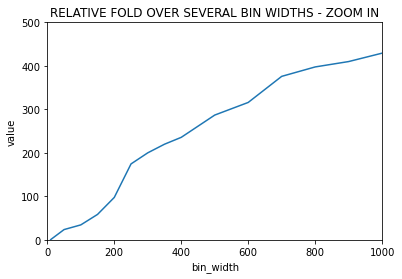

In [143]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'rel_fold'], x="index", y = 'value')
plt.xlabel('bin_width')
plt.xlim(0, 1000)
plt.ylim(0, 500)
plt.title("RELATIVE FOLD OVER SEVERAL BIN WIDTHS - ZOOM IN")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/relative_fold_over_bin_widths_zoom_in.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

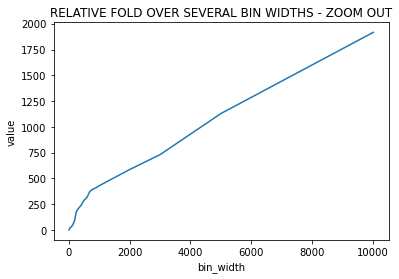

In [144]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'rel_fold'], x="index", y = 'value')
plt.xlabel('bin_width')
plt.title("RELATIVE FOLD OVER SEVERAL BIN WIDTHS - ZOOM OUT")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/relative_fold_over_bin_widths_zoom_out.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

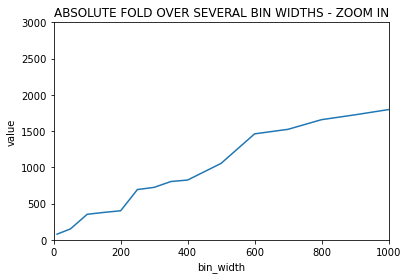

In [145]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'abs_fold'], x="index", y = 'value')
plt.xlabel('bin_width')
plt.xlim(0, 1000)
plt.ylim(0, 3000)
plt.title("ABSOLUTE FOLD OVER SEVERAL BIN WIDTHS - ZOOM IN")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/absolute_fold_over_bin_widths_zoom_in.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

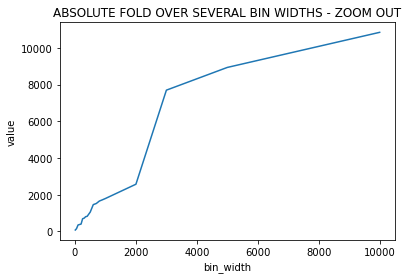

In [146]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'abs_fold'], x="index", y = 'value')
plt.xlabel('bin_width')
plt.title("ABSOLUTE FOLD OVER SEVERAL BIN WIDTHS - ZOOM OUT")
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/absolute_fold_over_bin_widths_zoom_out.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

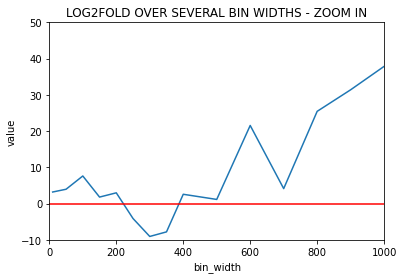

In [147]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'log2Fold'], x="index", y = 'value')
plt.xlim(0, 1000)
plt.ylim(-10, 50)
plt.xlabel('bin_width')
plt.title("LOG2FOLD OVER SEVERAL BIN WIDTHS - ZOOM IN")
graph.axhline(0, color = 'red')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/log2fold_over_bin_widths_zoom_in.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

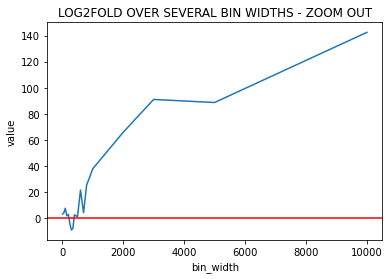

In [148]:
graph = sns.lineplot(data = possible_cis_stats.loc[possible_cis_stats['variable'] == 'log2Fold'], x="index", y = 'value')
plt.title("LOG2FOLD OVER SEVERAL BIN WIDTHS - ZOOM OUT")
plt.xlabel('bin_width')
graph.axhline(0, color = 'red')
plt.savefig('/research/projects/chlamydomonas/MAexpression/analysis/DEGs/cis_mutations/log2fold_over_bin_widths_zoom_out.pdf', format = 'pdf', dpi = 150, bbox_inches = 'tight')

### Divergence Info

In [17]:
import pandas as pd

divergence = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/divergence_info/divergence.out.txt', delimiter = '\t')
# network_stat = pd.read_csv('/research/projects/chlamydomonas/MAexpression/data/genome_info/divergence_info/network_divergence_diversity_statsmerged.txt', delimiter = '\t')
# network_stat.head()
divergence['transcript_ID'].to_csv('/research/projects/chlamydomonas/MAexpression/analysis/divergence_transcript_ID.txt', sep = ',', index = False, header = True)

In [18]:
divergence.head()

,transcript_ID,Cincerta_transcript_ID,PID,aligned_sites,k0,k4,diffs0,sites0,diffs4,sites4
0,26888200,g6935.t1,0.05,4171,0.008693,0.18207552577683572,24,2777,113,699
1,26904954,g13204.t1,0.09,1020,0.044015,0.19942765984278787,28,655,38,217
2,26894252,g11333.t1,0.15,4201,0.093115,0.4301792840669918,231,2638,311,950
3,26891814,g15729.t1,0.22,4096,0.194549,0.4704491069069298,450,2626,325,930
4,26901315,g5327.t1,0.05,2257,0.002026,0.19896085182196072,3,1483,72,412


### Seaborn

,variable,value,labels,genotype,mutations
samples,,,,,
CC2344-L1,FC.per.mut,85.237884,L1,CC2344,396.0
CC2344-L2,FC.per.mut,309.611696,L2,CC2344,80.0
CC2344-L3,FC.per.mut,539.342803,L3,CC2344,63.0
CC2344-L4,FC.per.mut,1271.601493,L4,CC2344,24.0
CC2344-L5,FC.per.mut,389.713818,L5,CC2344,68.0


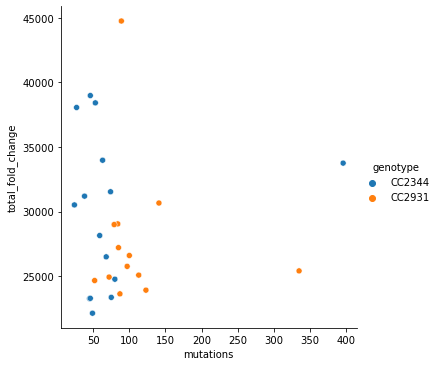

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

names = ['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15']

# SUM OF FOLD_CHANGE PER SAMPLE

FC_stats = pd.DataFrame()
data = pd.DataFrame()
data['samples'] = CC2344[1:] + CC2931[1:]
data.set_index('samples', inplace = True)

for i in names:
    for j in list(data.index.values):
        if i in j:
            data.at[j, 'labels'] = i

for i in CC2344[1:] + CC2931[1:]:
    data.at[i, 'generations'] = generations[i]
    data.at[i, 'mutations'] = mutations[i]
    if 'CC2344' in i:
        data.at[i, 'genotype'] = 'CC2344'
        data.at[i, 'total_fold_change'] = abs(CC2344_df[i]).sum()
        data.at[i, 'CC2344_total_FC'] = abs(CC2344_df[i]).sum()
        data.at[i, 'FC.per.mut'] = abs(CC2344_df[i]).sum()/mutations[i]
        data.at[i, 'FC.per.exp.mut'] = abs(CC2344_df[i]).sum()/expected_mut.at[i, 'exp_mut']
        data.at[i, 'FC.per.gen'] = abs(CC2344_df[i]).sum()/generations[i]
    if 'CC2931' in i:
        data.at[i, 'genotype'] = 'CC2931'
        data.at[i, 'total_fold_change'] = abs(CC2931_df[i]).sum()
        data.at[i, 'CC2931_total_FC'] = abs(CC2931_df[i]).sum()
        data.at[i, 'FC.per.mut'] = abs(CC2931_df[i]).sum()/mutations[i]
        data.at[i, 'FC.per.exp.mut'] = abs(CC2931_df[i]).sum()/expected_mut.at[i, 'exp_mut']
        data.at[i, 'FC.per.gen'] = abs(CC2931_df[i]).sum()/generations[i]
for i in CC2344[1:]:
    temp = CC2344_df[i].mask(CC2344_df[i] > 0, 0, inplace = False)
    data.at[i, 'CC2344_down_reg'] = temp.sum()
    temp = CC2344_df[i].mask(CC2344_df[i] < 0, 0, inplace = False)
    data.at[i, 'CC2344_up_reg'] = temp.sum()
        
for i in CC2931[1:]:
    temp = CC2931_df[i].mask(CC2931_df[i] > 0, 0, inplace = False)
    data.at[i, 'CC2931_down_reg'] = temp.sum()
    temp = CC2931_df[i].mask(CC2931_df[i] < 0, 0, inplace = False)
    data.at[i, 'CC2931_up_reg'] = temp.sum()
    
####################################################################################################################################################################################
    
# data_1 = pd.melt(data, id_vars = ['labels'], value_vars = ['CC2344_down_reg', 'CC2344_up_reg', 'CC2931_down_reg', 'CC2931_up_reg'])

# for i in list(data_1.index.values):
#     if 'CC2344' in data_1.at[i, 'variable']:
#         data_1.at[i, 'genotypes'] = 'CC2344'
#     if 'CC2931' in data_1.at[i, 'variable']:
#         data_1.at[i, 'genotypes'] = 'CC2931'
#     if 'up' in data_1.at[i, 'variable']:
#         data_1.at[i, 'regulated'] = 'up'
#     if 'down' in data_1.at[i, 'variable']:
#         data_1.at[i, 'regulated'] = 'down'
        
#################################################################################################################################################################################### 

data_2 = pd.melt(data.reset_index(), id_vars = 'samples', value_vars = ['FC.per.mut', 'FC.per.exp.mut'])
data_2.set_index('samples', inplace = True)

for i in names:
    for j in CC2344[1:] + CC2931[1:]:
        if i in j:
            data_2.at[j, 'labels'] = i
for i in list(data_2.index.values):
    if 'CC2344' in i:
        data_2.at[i, 'genotype'] = 'CC2344'
    if 'CC2931' in i:
        data_2.at[i, 'genotype'] = 'CC2931'
    data_2.at[i, 'mutations'] = mutations[i]

####################################################################################################################################################################################

# FC_stats['CC2344.UP'] = data['CC2344_up_reg'].describe()
# FC_stats['CC2344.DOWN'] = data['CC2344_down_reg'].describe()
# FC_stats['CC2931.UP'] = data['CC2931_up_reg'].describe()
# FC_stats['CC2931.DOWN'] = data['CC2931_down_reg'].describe()

# FC_stats['CC2344.TOTAL'] = data['CC2344_total_FC'].describe()
# FC_stats['CC2931.TOTAL'] = data['CC2931_total_FC'].describe()

# for i in CC2344[1:] + CC2931[1:]:
#     if 'CC2344' in i:
#         FC_stats[i] = CC2344_df[i].describe()
#     if 'CC2931' in i:
#         FC_stats[i] = CC2931_df[i].describe()   

############################################################################################################################

# sns.set_theme()
# sns.relplot(data = data, kind = 'scatter', x = 'generations', y = 'total_fold_change', hue = 'genotype', size = 'mutations')
# sns.relplot(data = data, kind = 'scatter', x = 'generations', y = 'total_fold_change', hue = 'samples', size = 'mutations')
# sns.relplot(data = data, kind = 'scatter', x = 'generations', y = 'total_fold_change', hue = 'samples')
# sns.relplot(data = data, kind = 'scatter', x = 'generations', y = 'total_fold_change', hue = 'genotype')
# sns.relplot(data = data, kind = 'scatter', x = 'mutations', y = 'total_fold_change', hue = 'samples')
# sns.relplot(data = data, kind = 'scatter', x = 'mutations', y = 'total_fold_change', hue = 'genotype')
# sns.relplot(data = data, kind = 'scatter', x = 'generations', y = 'mutations', hue = 'genotype')
# g = sns.relplot(data = data_1, kind = 'scatter', x = 'labels', y = 'value', hue = 'genotypes', style = 'regulated')
# g.set(ylim = (-30000,30000))
# g.set_axis_labels("MA lines", "fold change")

# sns.relplot(data = data, kind = 'scatter', x = 'FC.per.mut', y = 'FC.per.exp.mut', hue = 'genotype')
sns.relplot(data = data, kind = 'scatter', x = 'mutations', y = 'total_fold_change', hue = 'genotype')

############################################################################################################################

### Log2Fold Stats

In [1]:
# for i in CC2931_res:
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] < 0)
#     stats.at[i, 'sum_up'] = temp.sum()
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] > 0)
#     stats.at[i, 'sum_down'] = temp.sum()
#     stats['difference'] = stats['sum_up'] + stats['sum_down']
#     stats['CC2931_total_dif'] = stats['difference'].iloc[[0,12]].sum()
#     stats['CC2931_total_avg'] = stats['difference'].iloc[[0,12]].mean()
    
# for i in CC2344_res:
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] < 0)
#     stats.at[i, 'sum_up'] = temp.sum()
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] > 0)
#     stats.at[i, 'sum_down'] = temp.sum()
#     stats['difference'] = stats['sum_up'] + stats['sum_down']
#     stats['CC2344_total_dif'] = stats['difference'].iloc[[13, 27]].sum()
#     stats['CC2344_total_avg'] = stats['difference'].iloc[[13, 27]].mean()
# stats['ALL_total_dif'] = stats['difference'].sum()
# stats['ALL_total_avg'] = stats['difference'].mean()
# stats.head(n=32)

## LOG2FOLD STATS
    
# for i in CC2931_res:
#     stats.at[i, 'mean_log2_all'] = (CC2931_log2Fold[i].abs()).mean(axis = 0, skipna = True)
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] < 0)
#     stats.at[i, 'mean_log2_up'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_up'] = temp.count()
#     stats.at[i, 'percent_up'] = (temp.count()/CC2931_log2Fold[i].count())*100
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] < 1.5)
#     stats.at[i, 'mean_log2_above_1.5'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_above_1.5'] = temp.count()
#     stats.at[i, 'percent_above_1.5'] = (temp.count()/CC2931_log2Fold[i].count())*100
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] < 2)
#     stats.at[i, 'mean_log2_above_2'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_above_2'] = temp.count()
#     stats.at[i, 'percent_above_2'] = (temp.count()/CC2931_log2Fold[i].count())*100
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] > 0)
#     stats.at[i, 'mean_log2_down'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_down'] = temp.count()
#     stats.at[i, 'percent_down'] = (temp.count()/CC2931_log2Fold[i].count())*100
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] > -1.5)
#     stats.at[i, 'mean_log2_below_-1.5'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_below_-1.5'] = temp.count()
#     stats.at[i, 'percent_below_-1.5'] = (temp.count()/CC2931_log2Fold[i].count())*100
    
#     temp = CC2931_log2Fold[i].mask(CC2931_log2Fold[i] > -2)
#     stats.at[i, 'mean_log2_below_-2'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_below_-2'] = temp.count()
#     stats.at[i, 'percent_below_-2'] = (temp.count()/CC2931_log2Fold[i].count())*100

# for i in CC2344_res:
#     stats.at[i, 'mean_log2_all'] = (CC2344_log2Fold[i].abs()).mean(axis = 0, skipna = True)
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] < 0)
#     stats.at[i, 'mean_log2_up'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_up'] = temp.count()
#     stats.at[i, 'percent_up'] = (temp.count()/CC2344_log2Fold[i].count())*100
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] < 1.5)
#     stats.at[i, 'mean_log2_above_1.5'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_above_1.5'] = temp.count()
#     stats.at[i, 'percent_above_1.5'] = (temp.count()/CC2344_log2Fold[i].count())*100
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] < 2)
#     stats.at[i, 'mean_log2_above_2'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_above_2'] = temp.count()
#     stats.at[i, 'percent_above_2'] = (temp.count()/CC2344_log2Fold[i].count())*100
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] > 0)
#     stats.at[i, 'mean_log2_down'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_down'] = temp.count()
#     stats.at[i, 'percent_down'] = (temp.count()/CC2344_log2Fold[i].count())*100
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] > -1.5)
#     stats.at[i, 'mean_log2_below_-1.5'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_below_-1.5'] = temp.count()
#     stats.at[i, 'percent_below_-1.5'] = (temp.count()/CC2344_log2Fold[i].count())*100
    
#     temp = CC2344_log2Fold[i].mask(CC2344_log2Fold[i] > -2)
#     stats.at[i, 'mean_log2_below_-2'] = temp.mean(axis = 0, skipna = True)
#     stats.at[i, 'count_below_-2'] = temp.count()
#     stats.at[i, 'percent_below_-2'] = (temp.count()/CC2344_log2Fold[i].count())*100